# Truncated mass distribution collapse simulation

In this notwbook we're going to produce...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [57]:
# set initial variables/ uninitialized arrays

N = 100
m = 1
a = 1

In [58]:
from scipy.stats import uniform

Generating th masses of the truncated sphere: 

In [59]:
cdf_r = uniform.rvs(size=N)  # cumulative function of rs
rays = a * (cdf_r / 3)**1/3

cdf_theta = uniform.rvs(size=N)  # cumulative function of thetas
thetas = np.arccos(1 - 2 * cdf_theta)

phis = uniform.rvs(0, 2 * np.pi, size=N)

Generating the coordinates: 

In [60]:
x = rays * np.sin(thetas) * np.cos(phis)
y = rays * np.sin(thetas) * np.sin(phis)
z = rays * np.cos(thetas) 

Check with the 3D plot: 

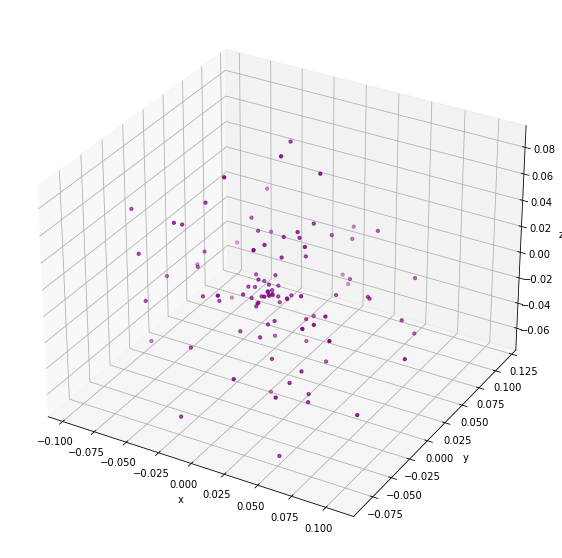

In [61]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c = 'purple', s=10.5)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

Now we want to check that equal volumes inside our distribution correspond to an equal number of masses: 

In [62]:
V_sphere = 4 * np.pi / 3 * a**3
test_frac = 100
V_test = V_sphere / test_frac

def VolumeTest(V_test, r, theta, phi): 
    
    # Uniform generation of the coordinates, otherwise it is a tautology
    
    rs_test = uniform.rvs(0, a, size=2)
    thetas_test = uniform.rvs(0, np.pi, size=2)
    phi1_test = uniform.rvs(0, 2 * np.pi)
    
    # Sorting to get the correct form of the result
    
    r1_test = rs_test.min()
    r2_test = rs_test.max()
    
    theta1_test = thetas_test.min()
    theta2_test = thetas_test.max()
    
    f_theta = 0.5*(- theta1_test + np.sin(theta1_test) * np.cos(theta1_test) + theta2_test - np.sin(theta2_test)*np.cos(theta2_test))
    
    phi2_test = phi1_test + 3 * V_test / (f_theta * (r2_test - r1_test)**3)
    
    # Check the points lying within the volume
    
    enclosed_points = ((r >= r1_test) & (r <= r2_test) & (theta >= theta1_test) & (theta <= theta2_test) & (phi >= phi1_test) & (phi <= phi2_test))
    
    # Count the number of enclosed points
    num_enclosed_points = np.sum(enclosed_points)
    
    return num_enclosed_points

In [63]:
Ntest = 10000

bodies_number_array = np.array([VolumeTest(V_test, rays, thetas, phis) for i in range(Ntest)])

expected_bodies = N / V_sphere * V_test

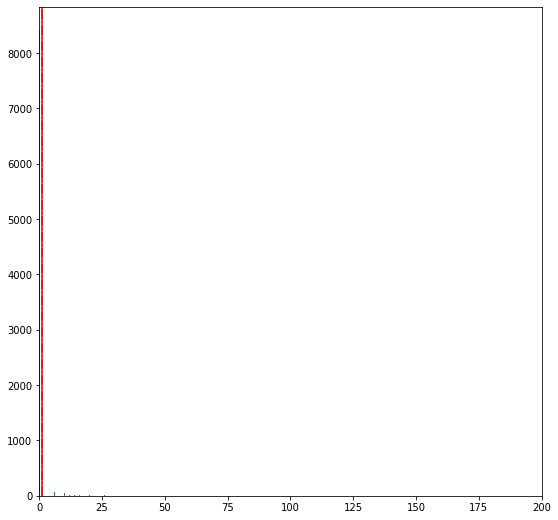

In [64]:
plt.figure(figsize = (9,9))

plt.hist(bodies_number_array, 1000)
plt.axvline(expected_bodies, ls='-.', c='green')
plt.axvline(np.mean(bodies_number_array), ls='-', c='r')
plt.xlim(0, 200)
plt.show()

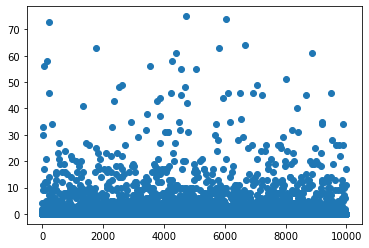

In [65]:
plt.scatter(np.arange(0, len(bodies_number_array)), bodies_number_array)

In [66]:
np.mean(bodies_number_array)

1.0692

In [67]:
len(bodies_number_array[bodies_number_array == 0])  # su 10000 7975 sono senza nessuna massa

8421

## Create initial conditions file

In [68]:
# open the file
file = open('homogeneous_sphere_initial.txt', 'w')

# write the file
file.write(f'{N}\n')
file.write('0\n')
for i in range(N):
    file.write(f'{m} {x[i]} {y[i]} {z[i]} {0} {0} {0}\n')

# close the file
file.close()

In [69]:
def dyn_time(rho_0): 
    
    G = 1
    
    return np.sqrt(3 * np.pi / (16 * G * rho_0))

def coll_time(rho_0): 
    
    G = 1
    
    return np.sqrt(3 * np.pi / (32 * G * rho_0))

Evaluate $\rho_0$: 

In [70]:
rho0 = V_sphere / N * 1  # masses of stars

In [71]:
rho0

0.041887902047863905

In [72]:
print(coll_time(rho0))

2.6516504294495533


In [73]:
print(dyn_time(rho0))

3.7500000000000004


## Simulation results: 

In [114]:
import pandas as pd

In [115]:
fname = 'collapse_results.out'

In [116]:
data = pd.read_csv(fname).to_numpy()

In [117]:
times = data[0::(N+2)].astype(float)

m = {}

for i in range(1, N + 1):
    
    m[f"{i}"]= data[i::(N+2)]

In [118]:
# produce a split array: 

m_data = {}

for j in range(1, N + 1):

    m_data[f"{j}"] = np.array([m[f"{j}"][i][0].split() for i in range(0, len(m[f"{j}"]))]).astype(float)

Just as a reminder of how to access the data: 

m1 = {
    
    "m1" : m1_data_1[:, 0],
    "x1" : m1_data_1[:, 1],
    "x2" : m1_data_1[:, 2],
    "x3" : m1_data_1[:, 3],
    "v1" : m1_data_1[:, 4],
    "v2" : m1_data_1[:, 5],
    "v3" : m1_data_1[:, 6]
    
}

In [119]:
times_plot = np.hstack(times)

<IPython.core.display.Javascript object>


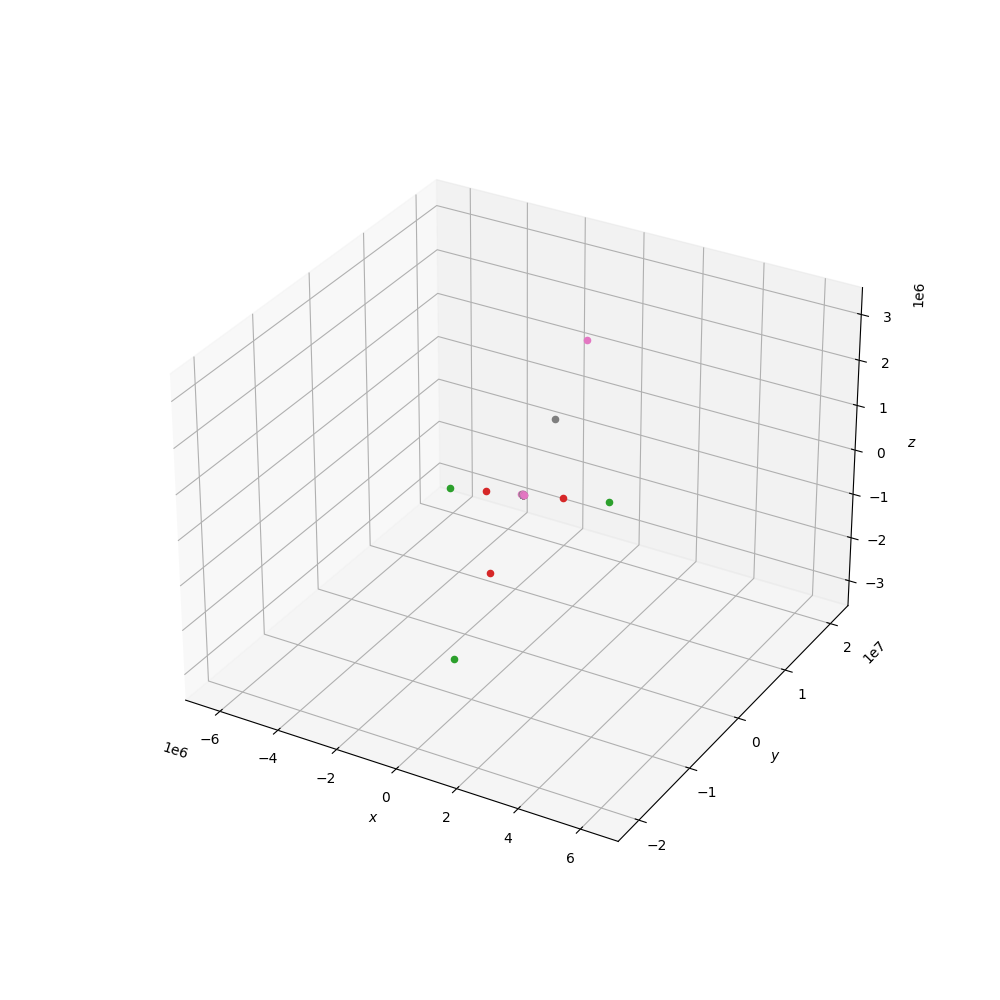

(-2.0, 2.0)

In [125]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,10))

for i in range(1, N + 1):

    ax.plot(m_data[f"{i}"][:, 1], m_data[f"{i}"][:, 2], m_data[f"{i}"][:, 3], label=f"{i}th particle", linestyle='--')

    
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

#plt.legend()

Let's see some animation, because this is kind of a mess :). 

In [136]:
import matplotlib.animation as animation

def update(num):
    
    ax.clear() 
    
    for i in range(1, N + 1): 
    
        #ax.scatter(m_data[f"{i}"][num + 1, 1], m_data[f"{i}"][num + 1, 2], m_data[f"{i}"][num + 1, 3], marker='o')             
        
        ax.scatter(m_data[f"{i}"][num, 1], m_data[f"{i}"][num, 2], m_data[f"{i}"][num, 3], marker='o')   
    
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_zlabel(r'$z$')
        ax.set_autoscale_on(False);
        

In [137]:
len(m_data[f"{i}"])

53

<IPython.core.display.Javascript object>


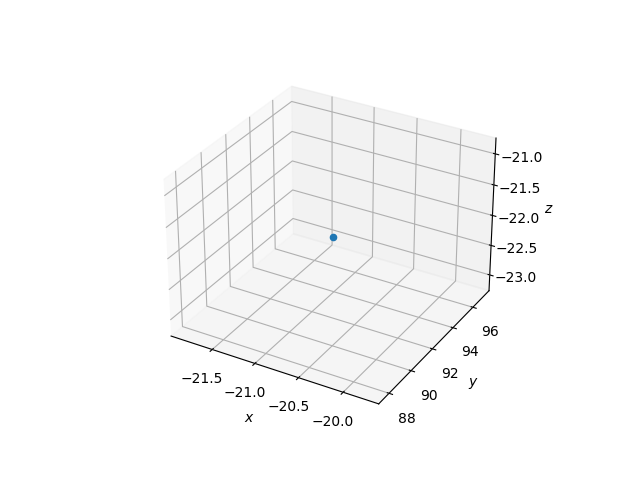

In [138]:
%matplotlib notebook 


## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
numDataPoints = 52
line_ani = animation.FuncAnimation(fig, update,   
                                   frames=numDataPoints)

# Saving the Animation
f = r"N_100.gif"
writergif = animation.PillowWriter(fps=10)
line_ani.save(f, writer=writergif);